<a href="https://colab.research.google.com/github/siris11/Time-series_hydrological-dynamics/blob/main/TSA_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [142]:
!pip install ruptures

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import shap
import seaborn as sns
import math

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [144]:
from zipfile import ZipFile
import os

zip_path = '/content/ID_5525500.zip'
unzip_dir = '/content/data_unzipped'

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

# List all files extracted
for root, dirs, files in os.walk(unzip_dir):
    for file in files:
        print(os.path.join(root, file))


/content/data_unzipped/ID_5525500/SW_ID_8796.csv
/content/data_unzipped/ID_5525500/Streamflow_05525500.csv
/content/data_unzipped/ID_5525500/SW_ID_8797.csv
/content/data_unzipped/ID_5525500/SW_ID_8795.csv
/content/data_unzipped/ID_5525500/Climate_05525500.csv
/content/data_unzipped/ID_5525500/AET_mean_avg_5525500.csv
/content/data_unzipped/ID_5525500/LULC_05525500.csv
/content/data_unzipped/ID_5525500/Baseflow_cumec.csv
/content/data_unzipped/ID_5525500/Basefow seperation/Baseflow in cfs.csv
/content/data_unzipped/ID_5525500/Basefow seperation/05525500.csv
/content/data_unzipped/ID_5525500/Codes/Streamflow missing values calculation.R
/content/data_unzipped/ID_5525500/Codes/Recession constant estimation_5525500.R


In [145]:
import pandas as pd

#file paths
base_path = "/content/data_unzipped/ID_5525500"
files = {
    "aet": f"{base_path}/AET_mean_avg_5525500.csv",
    "streamflow": f"{base_path}/Streamflow_05525500.csv",
    "baseflow": f"{base_path}/Baseflow_cumec.csv",
    "climate": f"{base_path}/Climate_05525500.csv"
}

# Load each dataset
aet_df = pd.read_csv(files["aet"])
streamflow_df = pd.read_csv(files["streamflow"])
baseflow_df = pd.read_csv(files["baseflow"])
climate_df = pd.read_csv(files["climate"])
lulc_df = pd.read_csv("/content/data_unzipped/ID_5525500/LULC_05525500.csv")

# printing values
{
    "AET": aet_df.head(),
    "Streamflow": streamflow_df.head(),
    "Baseflow": baseflow_df.head(),
    "Climate": climate_df.head(),
    "LULC": lulc_df.head()
}


{'AET':          date  AET_mean
 0  1950-01-01  0.312486
 1  1950-02-01  0.325642
 2  1950-03-01  0.778990
 3  1950-04-01  1.059177
 4  1950-05-01  2.862942,
 'Streamflow':          date       cumec
 0  01/01/1951    2.548512
 1  01/02/1951   11.326720
 2  01/03/1951   84.950400
 3  01/04/1951  100.241472
 4  01/05/1951   65.128640,
 'Baseflow':          date  Baseflow(cumec)
 0  01/01/1951         1.274257
 1  01/02/1951         6.662667
 2  01/03/1951        49.078448
 3  01/04/1951        70.608868
 4  01/05/1951        57.803430,
 'Climate':          date       prcp      tmin      tmax
 0  1951-01-01   0.000000 -8.450638  1.323599
 1  1951-01-02  19.660020 -2.013858  4.536923
 2  1951-01-03  15.529976  0.217470  7.758930
 3  1951-01-04   0.848358 -3.532425  5.581332
 4  1951-01-05   0.000000 -3.092862  1.683306,
 'LULC':    year    urbn    agrl    past    fomi  rngb    rnge  wehb    wetn  bsvg
 0  1951  0.0000  0.8283  0.0019  0.0119   0.0  0.1541   0.0  0.0038   0.0
 1  1952  0.00

In [146]:
print(aet_df.info())
print('\n')
print(streamflow_df.info())
print('\n')
print(baseflow_df.info())
print('\n')
print(climate_df.info())
print('\n')
print(lulc_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      825 non-null    object 
 1   AET_mean  825 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.0+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25596 entries, 0 to 25595
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    25568 non-null  object 
 1   cumec   25568 non-null  float64
dtypes: float64(1), object(1)
memory usage: 400.1+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25596 entries, 0 to 25595
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             25568 non-null  object 
 1   Baseflow(cumec)  25568 non-null  float64
dtypes: float64(1), object(1)
memory usage: 400.1+ KB
None


<class 'pa

In [147]:
# Converting to datetime
aet_df['date'] = pd.to_datetime(aet_df['date'])
streamflow_df['date'] = pd.to_datetime(streamflow_df['date'], format='%m/%d/%Y')
baseflow_df['date'] = pd.to_datetime(baseflow_df['date'], format='%m/%d/%Y')
climate_df['date'] = pd.to_datetime(climate_df['date'])

# Add 'year' column for grouping
aet_df['year'] = aet_df['date'].dt.year
streamflow_df['year'] = streamflow_df['date'].dt.year
baseflow_df['year'] = baseflow_df['date'].dt.year
climate_df['year'] = climate_df['date'].dt.year

# Aggregate to yearly data
aet_yearly = aet_df.groupby('year')['AET_mean'].mean().reset_index()
streamflow_yearly = streamflow_df.groupby('year')['cumec'].mean().reset_index()
baseflow_yearly = baseflow_df.groupby('year')['Baseflow(cumec)'].mean().reset_index()
climate_yearly = climate_df.groupby('year').agg({
    'prcp': 'sum',     # Total precipitation per year
    'tmin': 'mean',    # Average yearly minimum temperature
    'tmax': 'mean'     # Average yearly maximum temperature
}).reset_index()

{
    "AET Yearly": aet_yearly.head(),
    "Streamflow Yearly": streamflow_yearly.head(),
    "Baseflow Yearly": baseflow_yearly.head(),
    "Climate Yearly": climate_yearly.head(),
    "LULC": lulc_df.head()
}


{'AET Yearly':    year  AET_mean
 0  1950  1.879304
 1  1951  1.890094
 2  1952  1.892966
 3  1953  1.713721
 4  1954  1.634713,
 'Streamflow Yearly':      year      cumec
 0  1951.0  15.838323
 1  1952.0  10.266171
 2  1953.0   6.873612
 3  1954.0   2.471420
 4  1955.0   5.812888,
 'Baseflow Yearly':      year  Baseflow(cumec)
 0  1951.0        12.389901
 1  1952.0         8.170518
 2  1953.0         5.464242
 3  1954.0         1.971977
 4  1955.0         4.638171,
 'Climate Yearly':    year         prcp      tmin       tmax
 0  1951  1076.132216  3.597385  15.161223
 1  1952   921.840840  4.587535  16.924323
 2  1953   796.390342  4.933266  17.850891
 3  1954   828.122561  5.163938  17.414897
 4  1955   895.730579  4.324671  16.846530,
 'LULC':    year    urbn    agrl    past    fomi  rngb    rnge  wehb    wetn  bsvg
 0  1951  0.0000  0.8283  0.0019  0.0119   0.0  0.1541   0.0  0.0038   0.0
 1  1952  0.0000  0.8466  0.0010  0.0108   0.0  0.1378   0.0  0.0038   0.0
 2  1953  0.0000  0

In [148]:
print(climate_yearly['year'].unique())
print(aet_yearly['year'].unique())
print(streamflow_yearly['year'].unique())
print(baseflow_yearly['year'].unique())

[1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964
 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978
 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992
 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021 2022 2023]
[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]
[1951. 1952. 1953. 1954. 1955. 1956. 1957. 1958. 1959. 1960. 1961. 1962.
 1963. 1964. 1965. 1966. 1967. 1968. 1969. 1970. 1971. 1972. 1973. 1974.
 1975. 1976. 1977. 1978. 1979. 1980. 1981. 1982. 1983. 1984. 1985. 1986.
 1987. 1988. 1989. 1990. 1991. 1992. 1993. 1994. 1995. 199

In [149]:
lulc_df = pd.read_csv("/content/data_unzipped/ID_5525500/LULC_05525500.csv")
lulc_df

,year,urbn,agrl,past,fomi,rngb,rnge,wehb,wetn,bsvg
0,1951,0.0000,0.8283,0.0019,0.0119,0.0,0.1541,0.0,0.0038,0.0
1,1952,0.0000,0.8466,0.0010,0.0108,0.0,0.1378,0.0,0.0038,0.0
2,1953,0.0000,0.8399,0.0000,0.0124,0.0,0.1439,0.0,0.0038,0.0
3,1954,0.0000,0.8701,0.0000,0.0150,0.0,0.1111,0.0,0.0038,0.0
4,1955,0.0003,0.8631,0.0029,0.0089,0.0,0.1210,0.0,0.0038,0.0
...,...,...,...,...,...,...,...,...,...,...
65,2016,0.0145,0.9610,0.0000,0.0058,0.0,0.0149,0.0,0.0038,0.0
66,2017,0.0145,0.9562,0.0010,0.0039,0.0,0.0206,0.0,0.0038,0.0
67,2018,0.0145,0.9526,0.0010,0.0049,0.0,0.0232,0.0,0.0038,0.0
68,2019,0.0145,0.9416,0.0000,0.0052,0.0,0.0348,0.0,0.0038,0.0


In [150]:
soil_files = pd.read_csv("/content/data_unzipped/ID_5525500/SW_ID_8795.csv")
soil_files.isnull().sum()

,0
date,0
soil_moisture,0


In [151]:
# === SOIL MOISTURE CLEANING ===
soil_files = ["/content/data_unzipped/ID_5525500/SW_ID_8795.csv",
              "/content/data_unzipped/ID_5525500/SW_ID_8796.csv",
              "/content/data_unzipped/ID_5525500/SW_ID_8797.csv"]

soil_dfs = []
for i, path in enumerate(soil_files):
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df_yearly = df.groupby('year')['soil_moisture'].mean().reset_index()
    df_yearly.columns = ['year', f'soil_{8795+i}']
    soil_dfs.append(df_yearly)

# Merge all three soil moisture DataFrames on 'year'
soil_combined = soil_dfs[0]
for df in soil_dfs[1:]:
    soil_combined = soil_combined.merge(df, on='year', how='outer')

# Compute average soil moisture across the three sites
soil_combined['soil_moisture_avg'] = soil_combined.iloc[:, 1:4].mean(axis=1)

soil_yearly = soil_combined[['year', 'soil_moisture_avg']]

soil_yearly.head()

,year,soil_moisture_avg
0,1979,0.318804
1,1980,0.323263
2,1981,0.317629
3,1982,0.333927
4,1983,0.331135


In [152]:
# Merge all into one modeling DataFrame
df = aet_yearly \
    .merge(baseflow_yearly, on='year') \
    .merge(streamflow_yearly, on='year') \
    .merge(climate_yearly, on='year') \
    .merge(soil_yearly, on='year') \
    .merge(lulc_df, on='year')

#df = df.dropna()
print(df.head())

   year  AET_mean  Baseflow(cumec)      cumec         prcp      tmin  \
0  1979  1.707200        10.993093  13.845674   973.534437  3.100737   
1  1980  1.824224         7.822395   9.821171   813.356745  4.026436   
2  1981  1.958963        10.103155  12.682365  1095.414322  4.262451   
3  1982  1.756599        12.715069  15.932661  1039.690625  3.915598   
4  1983  1.701100        11.570937  14.561080   982.363455  4.893463   

        tmax  soil_moisture_avg   urbn    agrl   past    fomi  rngb    rnge  \
0  14.752824           0.318804  0.005  0.9669  0.001  0.0038   0.0  0.0196   
1  15.603908           0.323263  0.005  0.9777  0.001  0.0010   0.0  0.0116   
2  15.667654           0.317629  0.005  0.9783  0.000  0.0010   0.0  0.0120   
3  15.246745           0.333927  0.005  0.9816  0.001  0.0019   0.0  0.0067   
4  15.984609           0.331135  0.005  0.9142  0.000  0.0072   0.0  0.0698   

   wehb    wetn  bsvg  
0   0.0  0.0038   0.0  
1   0.0  0.0038   0.0  
2   0.0  0.0038   0.

In [153]:
df.isnull().sum()

,0
year,0
AET_mean,0
Baseflow(cumec),0
cumec,0
prcp,0
tmin,0
tmax,0
soil_moisture_avg,0
urbn,0
agrl,0


In [154]:
unique_years = df['year'].nunique()
unique_years #1979-2018
#print(f"Unique years range from {unique_years.min()} to {unique_years.max()}")

40

In [155]:
df.head()

,year,AET_mean,Baseflow(cumec),cumec,prcp,tmin,tmax,soil_moisture_avg,urbn,agrl,past,fomi,rngb,rnge,wehb,wetn,bsvg
0,1979,1.707200,10.993093,13.845674,973.534437,3.100737,14.752824,0.318804,0.005,0.9669,0.001,0.0038,0.0,0.0196,0.0,0.0038,0.0
1,1980,1.824224,7.822395,9.821171,813.356745,4.026436,15.603908,0.323263,0.005,0.9777,0.001,0.0010,0.0,0.0116,0.0,0.0038,0.0
2,1981,1.958963,10.103155,12.682365,1095.414322,4.262451,15.667654,0.317629,0.005,0.9783,0.000,0.0010,0.0,0.0120,0.0,0.0038,0.0
3,1982,1.756599,12.715069,15.932661,1039.690625,3.915598,15.246745,0.333927,0.005,0.9816,0.001,0.0019,0.0,0.0067,0.0,0.0038,0.0
4,1983,1.701100,11.570937,14.561080,982.363455,4.893463,15.984609,0.331135,0.005,0.9142,0.000,0.0072,0.0,0.0698,0.0,0.0038,0.0


In [156]:
print(df['rngb'].value_counts())
print(df['wehb'].value_counts())
print(df['bsvg'].value_counts())

rngb
0.0    40
Name: count, dtype: int64
wehb
0.0    40
Name: count, dtype: int64
bsvg
0.0    40
Name: count, dtype: int64


In [157]:
features = list(df.columns)
print(features)

['year', 'AET_mean', 'Baseflow(cumec)', 'cumec', 'prcp', 'tmin', 'tmax', 'soil_moisture_avg', 'urbn', 'agrl', 'past', 'fomi', 'rngb', 'rnge', 'wehb', 'wetn', 'bsvg']


In [158]:
df.drop(columns=['rngb', 'wehb', 'bsvg'], axis=1, inplace=True)
df

,year,AET_mean,Baseflow(cumec),cumec,prcp,tmin,tmax,soil_moisture_avg,urbn,agrl,past,fomi,rnge,wetn
0,1979,1.707200,10.993093,13.845674,973.534437,3.100737,14.752824,0.318804,0.0050,0.9669,0.0010,0.0038,0.0196,0.0038
1,1980,1.824224,7.822395,9.821171,813.356745,4.026436,15.603908,0.323263,0.0050,0.9777,0.0010,0.0010,0.0116,0.0038
2,1981,1.958963,10.103155,12.682365,1095.414322,4.262451,15.667654,0.317629,0.0050,0.9783,0.0000,0.0010,0.0120,0.0038
3,1982,1.756599,12.715069,15.932661,1039.690625,3.915598,15.246745,0.333927,0.0050,0.9816,0.0010,0.0019,0.0067,0.0038
4,1983,1.701100,11.570937,14.561080,982.363455,4.893463,15.984609,0.331135,0.0050,0.9142,0.0000,0.0072,0.0698,0.0038
5,1984,1.688141,11.683099,14.699095,928.004239,4.675277,15.671002,0.334873,0.0050,0.9797,0.0000,0.0019,0.0096,0.0038
6,1985,1.775215,12.806935,16.117767,1098.236090,3.980757,15.632968,0.328890,0.0050,0.9826,0.0000,0.0019,0.0067,0.0038
7,1986,1.900566,8.742257,10.967314,822.003335,5.219688,16.567975,0.323568,0.0050,0.9618,0.0000,0.0039,0.0255,0.0038
8,1987,1.835450,4.943941,6.265786,878.732570,5.543097,17.289052,0.320956,0.0059,0.9333,0.0010,0.0032,0.0528,0.0038
9,1988,1.298331,3.936125,4.898861,709.351683,3.943385,17.211156,0.315423,0.0059,0.9196,0.0000,0.0029,0.0678,0.0038


In [159]:
df.to_csv('df.csv', index=False)

In [160]:
df = pd.read_csv('df.csv')
df.head()

,year,AET_mean,Baseflow(cumec),cumec,prcp,tmin,tmax,soil_moisture_avg,urbn,agrl,past,fomi,rnge,wetn
0,1979,1.707200,10.993093,13.845674,973.534437,3.100737,14.752824,0.318804,0.005,0.9669,0.001,0.0038,0.0196,0.0038
1,1980,1.824224,7.822395,9.821171,813.356745,4.026436,15.603908,0.323263,0.005,0.9777,0.001,0.0010,0.0116,0.0038
2,1981,1.958963,10.103155,12.682365,1095.414322,4.262451,15.667654,0.317629,0.005,0.9783,0.000,0.0010,0.0120,0.0038
3,1982,1.756599,12.715069,15.932661,1039.690625,3.915598,15.246745,0.333927,0.005,0.9816,0.001,0.0019,0.0067,0.0038
4,1983,1.701100,11.570937,14.561080,982.363455,4.893463,15.984609,0.331135,0.005,0.9142,0.000,0.0072,0.0698,0.0038


In [161]:
# === Units for reference ===
# year: Year (unitless)
# cumec: Streamflow (m³/s)
# Baseflow(cumec): Baseflow (m³/s)
# AET_mean: Actual Evapotranspiration (mm/day)
# prcp: Precipitation (mm)
# tmin, tmax: Temperature (°C)
# soil_moisture_avg: Soil Moisture (m³/m³)
# LULC variables (urbn, agrl, etc.): Land use fraction (0-1, unitless)

In [162]:
df.describe()

,year,AET_mean,Baseflow(cumec),cumec,prcp,tmin,tmax,soil_moisture_avg,urbn,agrl,past,fomi,rnge,wetn
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,4.000000e+01
mean,1998.500000,1.856992,10.039124,12.630666,983.278853,4.764753,16.358652,0.327676,0.010235,0.963682,0.000322,0.002615,0.019330,3.800000e-03
std,11.690452,0.188640,3.688981,4.666140,142.131550,0.842007,0.917428,0.006712,0.003608,0.014298,0.000518,0.001541,0.013963,1.317617e-18
min,1979.000000,1.298331,2.916053,3.681772,709.351683,3.100737,14.590566,0.313887,0.005000,0.914200,0.000000,0.000100,0.006700,3.800000e-03
25%,1988.750000,1.771351,8.158717,10.280709,878.515049,4.096218,15.664525,0.321958,0.005900,0.960850,0.000000,0.001675,0.012075,3.800000e-03
50%,1998.500000,1.829837,9.638409,12.121621,977.948946,4.787734,16.383105,0.329154,0.011200,0.967150,0.000000,0.002900,0.015600,3.800000e-03
75%,2008.250000,1.951140,11.887590,14.961197,1062.551060,5.241508,17.140413,0.333664,0.013600,0.971100,0.001000,0.003800,0.020350,3.800000e-03
max,2018.000000,2.558415,20.749842,25.987297,1379.716468,6.963417,18.680939,0.337425,0.014500,0.982600,0.001900,0.007200,0.069800,3.800000e-03


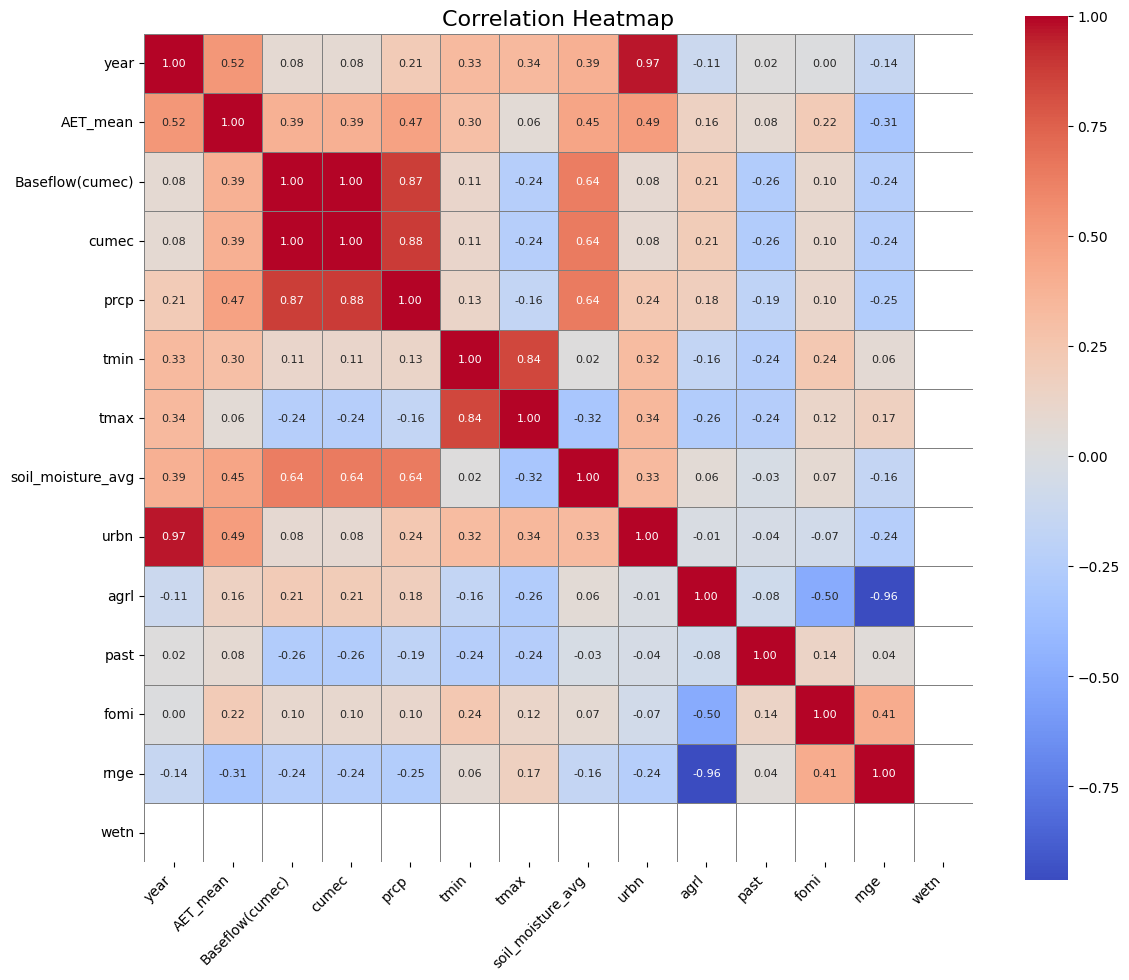

In [163]:
df_corr = df.dropna(axis=1, how='all')
df_corr = df_corr.loc[:, df_corr.nunique() > 1]

numerical_feats = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_feats.corr()
# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, cbar=True, linewidths=0.5, linecolor='gray',
            annot_kws={"size": 8}, mask=correlation_matrix.isnull())

plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

- **Streamflow**, **Baseflow(cumec)**, and **prcp** show strong positive correlations (ρ ≈ 0.88–1.00), indicating that precipitation and baseflow are key contributors to streamflow.

- **soil_moisture_avg** is moderately correlated with **streamflow **(ρ ≈ 0.64), suggesting that wetter soils enhance runoff and flow.

- **tmin** and **tmax** have a strong positive correlation (ρ ≈ 0.84), reflecting consistent temperature trends.

- **agrl (agricultural land)** shows weak to moderate negative correlations with streamflow (ρ ≈ -0.26) and very strong inverse relation with** mge (ρ ≈ -0.96)**, indicating possible land cover trade-offs.

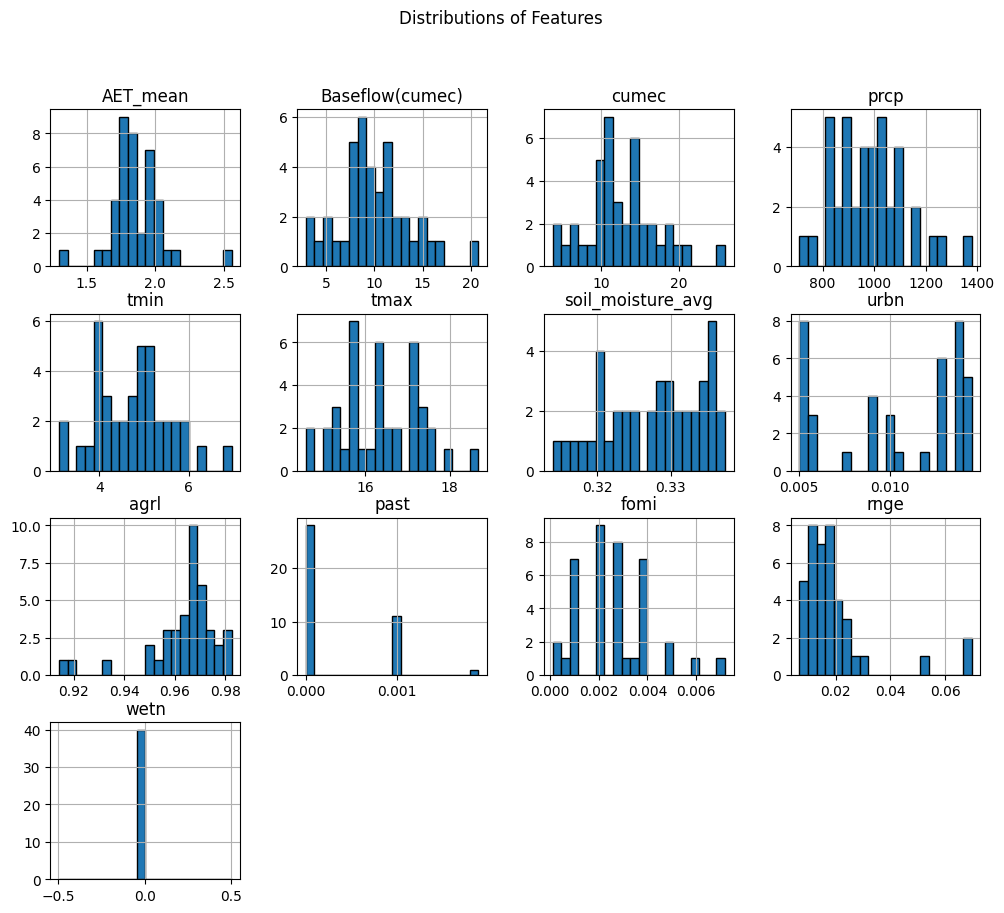

In [164]:
# Histogram of each feature
df.drop(columns='year').hist(bins=20, figsize=(12, 10), edgecolor='black')
plt.suptitle("Distributions of Features")
plt.show()

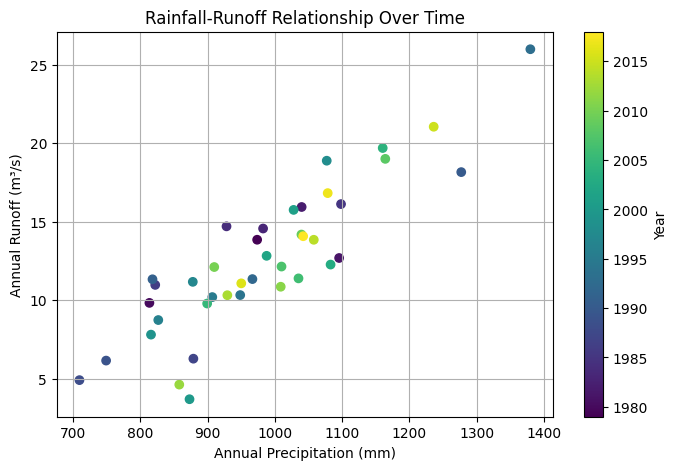

In [165]:
#Plot rainfall-runoff relationship over time
plt.figure(figsize=(8, 5))
plt.scatter(df['prcp'], df['cumec'], c=df['year'], cmap='viridis')
plt.xlabel("Annual Precipitation (mm)")
plt.ylabel("Annual Runoff (m³/s)")
plt.title("Rainfall-Runoff Relationship Over Time")
plt.colorbar(label='Year')
plt.grid(True)
plt.show()

In [166]:
!pip install pymannkendall

In [176]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def seq_mk(data):
    """
    Sequential Mann-Kendall test.
    Input: 2-column NumPy array or DataFrame with [year, values]
    Output: DataFrame with columns [u_prog, u_retr, turning_point]
    """
    year = data[:, 0]
    values = data[:, 1]
    m = len(values)

    # Progressive series
    n = np.zeros((m, m))
    for j in range(m):
        for i in range(j):
            n[j, i] = 1 if values[j] > values[i] else 0
    num = np.sum(n, axis=1)
    t = np.cumsum(num)
    var = np.array([i * (i - 1) * (2 * i + 5) / 72 for i in range(1, m + 1)])
    mean = np.array([i * (i - 1) / 4 for i in range(1, m + 1)])
    u_prog = (t - mean) / np.sqrt(var)

    # Retrograde series
    values_rev = values[::-1]
    n1 = np.zeros((m, m))
    for j in range(m):
        for i in range(j):
            n1[j, i] = 1 if values_rev[j] > values_rev[i] else 0
    num1 = np.sum(n1, axis=1)
    t1 = np.cumsum(num1)
    var1 = var
    mean1 = mean
    u_retr = (t1 - mean1) / np.sqrt(var1)
    u_retr = u_retr[::-1]

    # Turning points
    diff = u_prog - u_retr
    turning_point = np.zeros(m)
    for i in range(1, m - 2):
        if np.sign(diff[i]) != np.sign(diff[i + 1]):
            turning_point[i + 1] = 1

    # Plot
    # plt.figure(figsize=(10, 5))
    # plt.plot(year, u_prog, 'r', label='Progressive Series')
    # plt.plot(year, u_retr, 'b', label='Retrograde Series')
    # plt.grid(True)
    # plt.title('Sequential Mann-Kendall Test')
    # plt.xlabel('Year')
    # plt.legend()
    # plt.show()

    return pd.DataFrame({
        'year': year,
        'u_prog': u_prog,
        'u_retr': u_retr,
        'turning_point': turning_point.astype(int)
    })


In [177]:
#Applying S M Test to streamflow
df = pd.read_csv('df.csv')
data_array = df[['year', 'cumec']].to_numpy()
result = seq_mk(data_array)

# View detected change years
change_years = result[result['turning_point'] == 1]['year'].values
print("Non-stationary turning point years:", change_years)


Non-stationary turning point years: [1982. 1989. 1990. 1997. 1998. 2000. 2004. 2007. 2008. 2014. 2016. 2017.]


In [178]:
features = ['AET_mean','Baseflow(cumec)','cumec','prcp','tmin','tmax',
            'soil_moisture_avg','urbn','agrl']

for feat in features:
    print(f"Testing variable: {feat}")
    data_array = df[['year', feat]].to_numpy()
    result = seq_mk(data_array)
    turning_years = result[result['turning_point'] == 1]['year'].values
    if len(turning_years) > 0:
        print("Turning point(s) found in year(s):", turning_years)
    else:
        print("No turning point found.")
    print('\n')

Testing variable: AET_mean
No turning point found.


Testing variable: Baseflow(cumec)
Turning point(s) found in year(s): [1982. 1989. 1990. 1997. 1998. 2000. 2004. 2014. 2016. 2017.]


Testing variable: cumec
Turning point(s) found in year(s): [1982. 1989. 1990. 1997. 1998. 2000. 2004. 2007. 2008. 2014. 2016. 2017.]


Testing variable: prcp
Turning point(s) found in year(s): [1989. 1990. 2000. 2003.]


Testing variable: tmin
No turning point found.


Testing variable: tmax
No turning point found.


Testing variable: soil_moisture_avg
No turning point found.


Testing variable: urbn
No turning point found.


Testing variable: agrl
No turning point found.




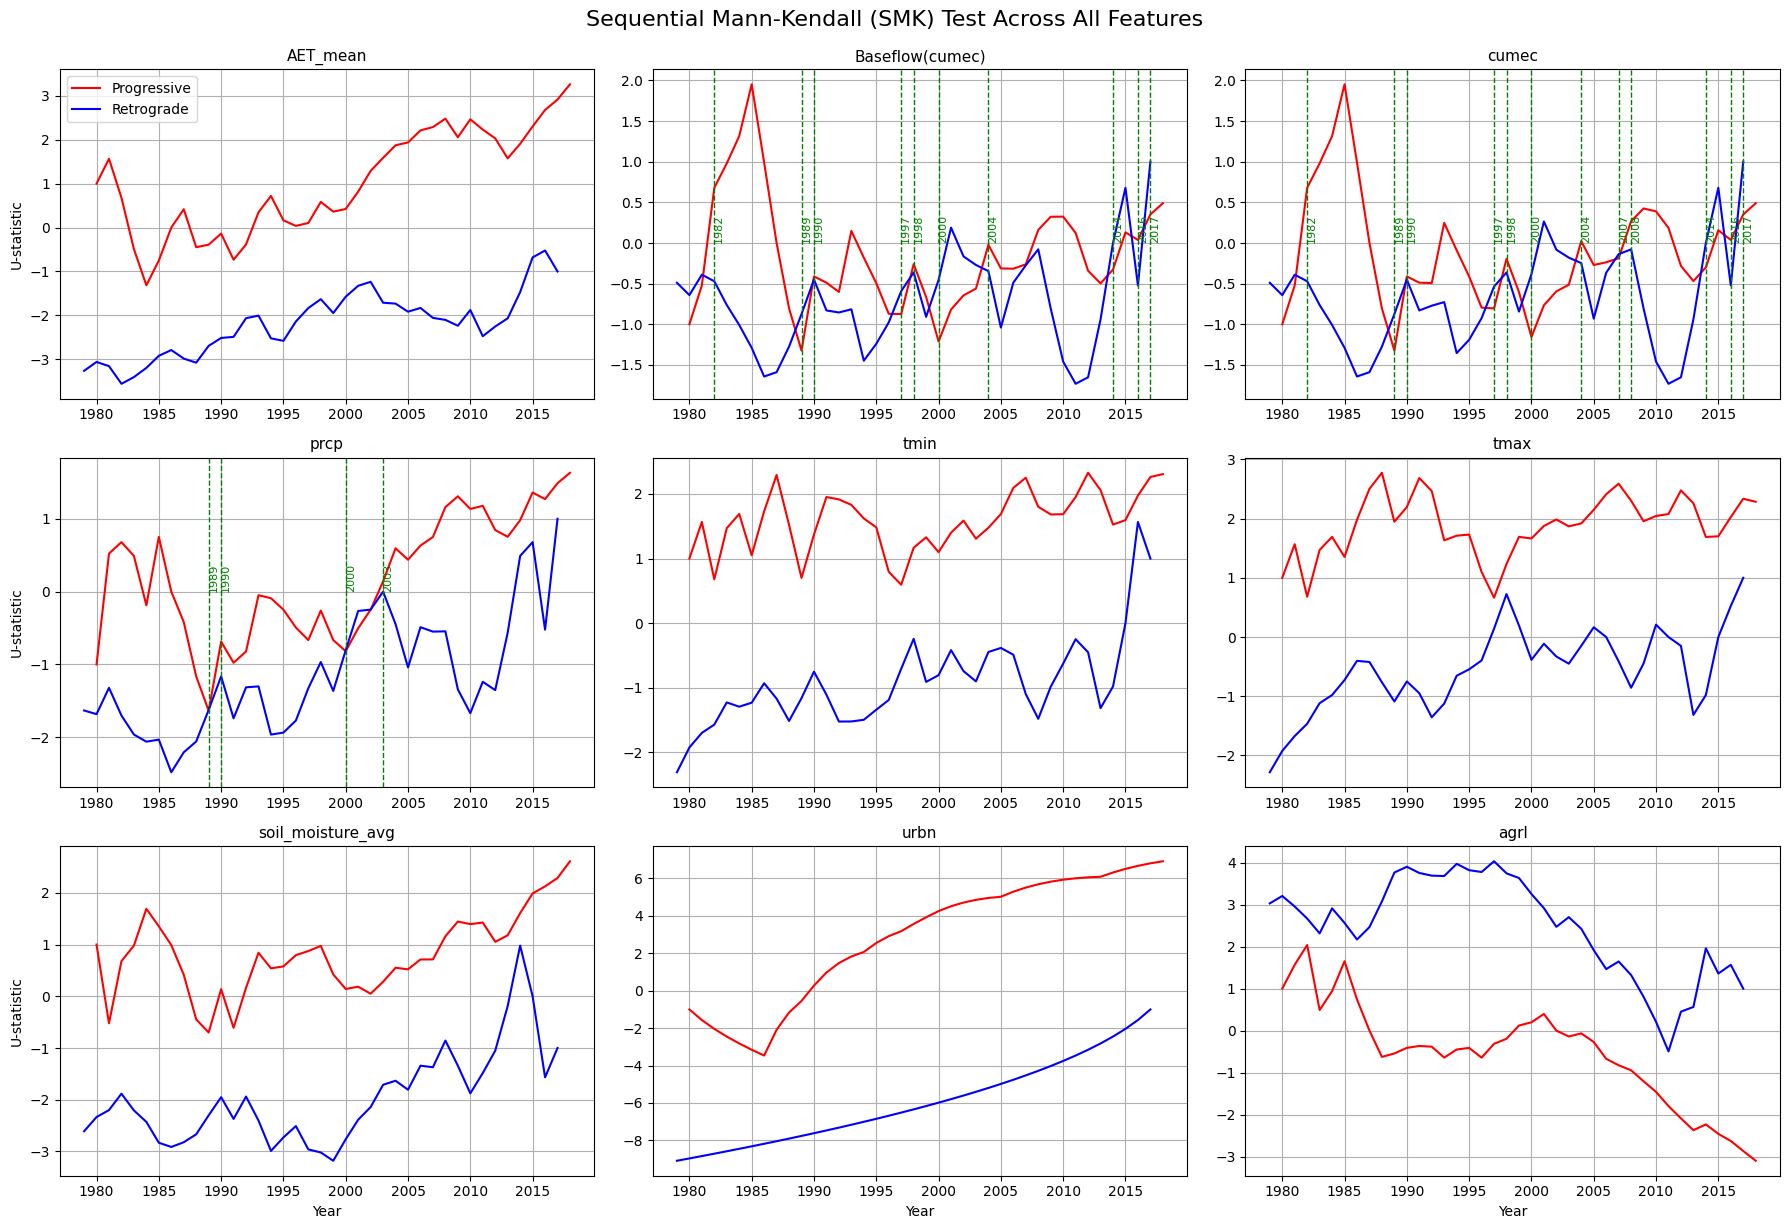

In [179]:
df = pd.read_csv("df.csv")

# List of features to analyze
features = ['AET_mean', 'Baseflow(cumec)', 'cumec', 'prcp', 'tmin', 'tmax',
            'soil_moisture_avg', 'urbn', 'agrl']

# Plot configuration
cols = 3
rows = math.ceil(len(features) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
axes = axes.flatten()

# Sequential MK for each feature
for idx, feature in enumerate(features):
    ax = axes[idx]
    data_array = df[['year', feature]].to_numpy()
    result = seq_mk(data_array)

    year = result['year']
    u_prog = result['u_prog']
    u_retr = result['u_retr']
    turning_years = result[result['turning_point'] == 1]['year'].values

    ax.plot(year, u_prog, 'r', label='Progressive')
    ax.plot(year, u_retr, 'b', label='Retrograde')

    for ty in turning_years:
        ax.axvline(ty, color='green', linestyle='--', linewidth=1)
        ax.text(ty, 0, f'{int(ty)}', color='green', fontsize=8, rotation=90, va='bottom')

    ax.set_title(f"{feature}", fontsize=11)
    ax.grid(True)

    if idx % cols == 0:
        ax.set_ylabel("U-statistic")
    if idx >= (rows - 1) * cols:
        ax.set_xlabel("Year")

# Remove empty subplots if any
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

# Final touches
fig.tight_layout()
fig.suptitle("Sequential Mann-Kendall (SMK) Test Across All Features", fontsize=16, y=1.02)
axes[0].legend()
plt.show()

# Model training

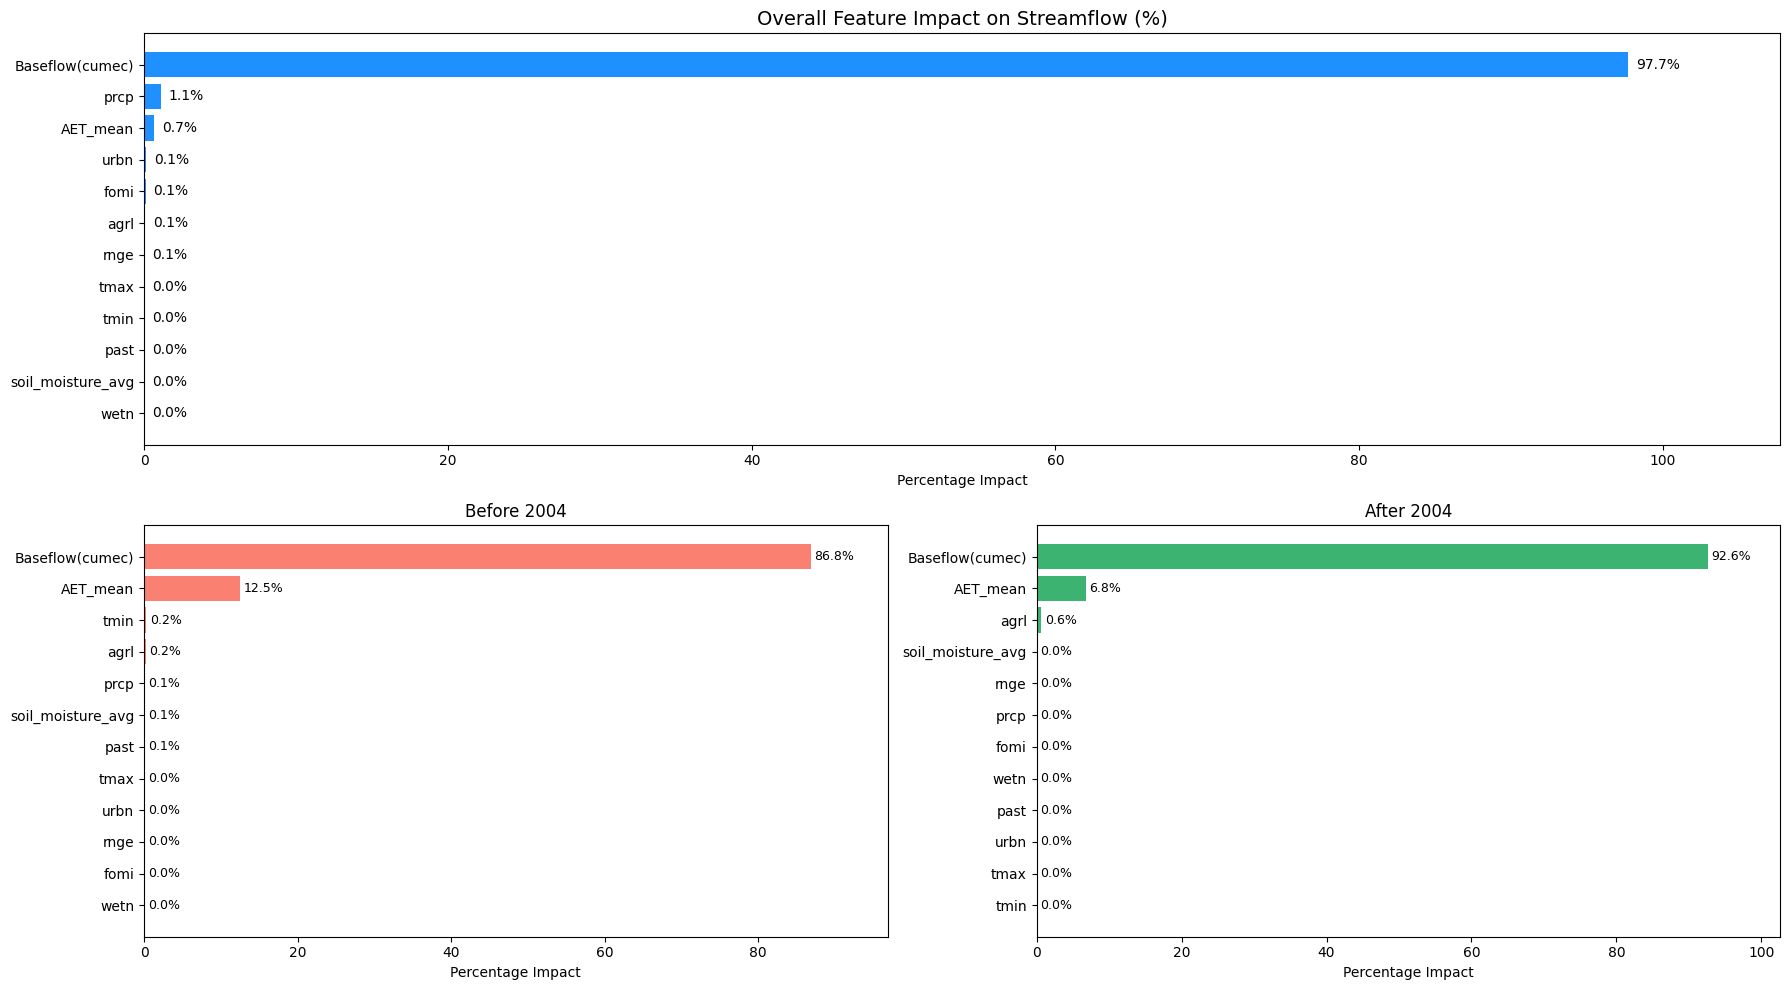

In [171]:
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# data
df = df.copy()

# Define target and features
target = 'cumec'
features = [col for col in df.columns if col not in ['year', target]]

# Change point
change_point = 2004
df_before = df[df['year'] <= change_point]
df_after = df[df['year'] > change_point]

X = df[features]
y = df[target]
X_before = df_before[features]
y_before = df_before[target]
X_after = df_after[features]
y_after = df_after[target]

# Train models
model_full = xgb.XGBRegressor(n_estimators=100, random_state=42)
model_full.fit(X, y)

model_before = xgb.XGBRegressor(n_estimators=100, random_state=42)
model_before.fit(X_before, y_before)

model_after = xgb.XGBRegressor(n_estimators=100, random_state=42)
model_after.fit(X_after, y_after)

# Use SHAP TreeExplainer
explainer_full = shap.TreeExplainer(model_full)
explainer_before = shap.TreeExplainer(model_before)
explainer_after = shap.TreeExplainer(model_after)

shap_values_full = explainer_full.shap_values(X)
shap_values_before = explainer_before.shap_values(X_before)
shap_values_after = explainer_after.shap_values(X_after)

# Feature importance calculation
def get_percentage_impact(shap_vals, columns):
    mean_abs = np.abs(shap_vals).mean(axis=0)
    pct = 100 * mean_abs / mean_abs.sum()
    return pd.Series(pct, index=columns).sort_values()

# Calculate
imp_full = get_percentage_impact(shap_values_full, features)
imp_before = get_percentage_impact(shap_values_before, features)
imp_after = get_percentage_impact(shap_values_after, features)

# Plotting
fig = plt.figure(figsize=(18, 10))

# Full dataset (big)
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax1.barh(imp_full.index, imp_full.values, color='dodgerblue')
ax1.set_title("Overall Feature Impact on Streamflow (%)", fontsize=14)
for i, v in enumerate(imp_full.values):
    ax1.text(v + 0.5, i, f"{v:.1f}%", va='center', fontsize=10)
ax1.set_xlim(0, imp_full.values.max() + 10)
ax1.set_xlabel("Percentage Impact")

# Before
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax2.barh(imp_before.index, imp_before.values, color='salmon')
ax2.set_title(f"Before {change_point}", fontsize=12)
for i, v in enumerate(imp_before.values):
    ax2.text(v + 0.5, i, f"{v:.1f}%", va='center', fontsize=9)
ax2.set_xlim(0, imp_before.values.max() + 10)
ax2.set_xlabel("Percentage Impact")

# After
ax3 = plt.subplot2grid((2, 2), (1, 1))
ax3.barh(imp_after.index, imp_after.values, color='mediumseagreen')
ax3.set_title(f"After {change_point}", fontsize=12)
for i, v in enumerate(imp_after.values):
    ax3.text(v + 0.5, i, f"{v:.1f}%", va='center', fontsize=9)
ax3.set_xlim(0, imp_after.values.max() + 10)
ax3.set_xlabel("Percentage Impact")

plt.tight_layout()
plt.show()
